In [27]:
import pandas as pd

import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import re, random
from torch import tensor
%matplotlib inline

In [28]:
df = pd.read_csv('PokemonStats.csv')

In [29]:
# Helper functions
def get_type_using_pokemon_name(pokemon):
    row = df[df['Pokemon'] == pokemon]['Type']

    if len(row):
        return row.values[0].split(', ')
    return None
def imshow(img):
    plt.imshow(np.transpose(img/2+0.5, (1, 2, 0)))
    

def plot_loss_curves(train_losses, valid_losses):
    """
    Plot the loss curves for both training and validation sets.
    
    Args:
        train_losses (list): List of training losses across epochs.
        valid_losses (list): List of validation losses across epochs.
    """
    epochs = range(1, len(train_losses) + 1)
    
    plt.figure(figsize=(10, 6))
    plt.plot(epochs, train_losses, label='Training Loss')
    plt.plot(epochs, valid_losses, label='Validation Loss')
    
    plt.title('Loss Curves', fontsize=16)
    plt.xlabel('Epoch', fontsize=14)
    plt.ylabel('Loss', fontsize=14)
    plt.legend()
    plt.grid()
    plt.show()
    

def keep_alpha_chars(input_string):
    # Using regular expression to remove non-alphabetic characters
    return re.sub(r'[^a-zA-Z\s\-.\'"]', '', input_string)

def get_random_label_vector(mlb, classes):
    random_number = random.randint(0, 17)
    return mlb.transform([classes[random_number]])[0]

def tensor_to_label(mlb, t):
    payload = tensor([t.tolist()])
    return ",".join(mlb.inverse_transform(payload)[0])




In [30]:
# Handling multiLabelBinarizer
classes = list(set([tt for typex in list(df['Type']) for tt in typex.split(", ")]))
classes = [[c] for c in classes]

from sklearn.preprocessing import MultiLabelBinarizer
mlb = MultiLabelBinarizer()
mlb.fit(classes)

temp = mlb.transform([["Ice", "Fire",]])
print("Encoded = ", temp)

decoded = mlb.inverse_transform(temp)
print("Decoded = ",decoded)

Encoded =  [[0 0 0 0 0 0 1 0 0 0 0 1 0 0 0 0 0 0]]
Decoded =  [('Fire', 'Ice')]


In [49]:
# Defining the custom image dataset
from torchvision.datasets import ImageFolder
class CustomImageDataset(ImageFolder):
    def __init__(self, root, transform=None):
        self.root_dir = root
        self.transform = transform
        self.present = 0
        self.absent = 0
        super().__init__(self.root_dir, self.transform)
    
    def __len__(self):
        return len(self.samples)
    
    def __getitem__(self, index):
        path, target = self.samples[index]
        sample = self.loader(path)
        if self.transform is not None:
            sample = self.transform(sample)

        # get_type_using_pokemon_name(self.samples[index].split('/')[1])
        pokemon = self.samples[index][0].split('/')[1]
        filename = self.samples[index][0].split('/')[2]
        label = get_type_using_pokemon_name(keep_alpha_chars(pokemon))
        if label is None:
            return sample, filename, get_random_label_vector(mlb, classes)
            # return None, None
        return sample, pokemon, mlb.transform([label])[0]

In [56]:
#generating the custom datasets from the Imagefodler

train_dir = "TrainImages"
test_dir = "TestImages"

pokemon_transform = transforms.Compose([
    transforms.Resize((128, 128)),  # Increase image size for better feature extraction
    transforms.RandomRotation(10),   # Randomly rotate images to augment dataset
    transforms.RandomHorizontalFlip(),  # Randomly flip images horizontally to augment dataset
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),  # Adjust brightness, contrast, saturation, and hue
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])  # Normalize with ImageNet mean and standard deviation
])

train_data = CustomImageDataset(root=train_dir, transform=pokemon_transform)
test_data = CustomImageDataset(root=test_dir, transform=pokemon_transform)


In [57]:
# Split train into train/validation (USING ONLY POKEMONS PRESENT IN THE CSV)

import numpy as np

present_indices = []

for i,c in enumerate(train_data.classes):
    if get_type_using_pokemon_name(keep_alpha_chars(c)): # using only CSV present pokemons for training for now.
        present_indices.append(i) # appending csv present pookemons in the list.
        
valid_size = 0.2
num_train = len(present_indices)
indices = present_indices
np.random.shuffle(indices)
split = int(np.floor(num_train * valid_size))
train_indices = indices[split:]
valid_indices = indices[:split]

In [58]:
# Using subset randomsampler to use the index to form sampler
from torch.utils.data.sampler import SubsetRandomSampler

train_sampler = SubsetRandomSampler(train_indices)
valid_sampler = SubsetRandomSampler(valid_indices)


In [59]:
# Using randomsampler to generrate Dataloaders
from torch.utils.data import DataLoader
train_loader = DataLoader(train_data, batch_size=32, sampler=train_sampler)
valid_loader = DataLoader(train_data, batch_size=32, sampler=valid_sampler)
test_loader = DataLoader(test_data, batch_size=32)


## Check or visualize sample data from train_loader


Pokemon:  Fletchinder
Y:  tensor([0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])


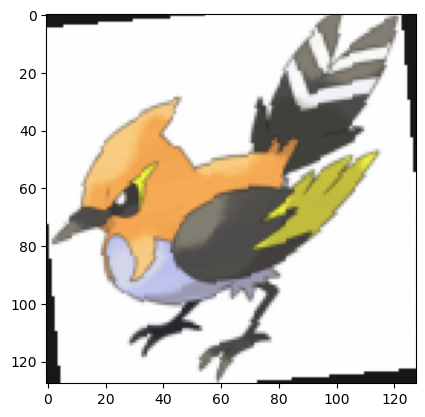

In [60]:
# Check visualize sample data from train_loader
dataiter = iter(train_loader)
images, pokemon, labels = next(dataiter)

print("Pokemon: ", pokemon[0])
# for index in np.arange(32):
print("Y: ", labels[0])


# print("Label: ", mlb.inverse_transform(tensor([labels[0]])))
imshow(images[0])


# Defining our Pokemon CNN model

In [37]:
import torch.nn as nn

class PokemonTypeCNN(nn.Module):
    def __init__(self, num_pokemon_types):
        super(PokemonTypeCNN, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        self.classifier = nn.Sequential(
            nn.Dropout(p=0.5),
            nn.Linear(256 * 8 * 8, 512),  # Adjusted input size based on the image size (32x32 after 3 max pooling layers)
            nn.ReLU(inplace=True),
            nn.Dropout(p=0.5),
            nn.Linear(512, num_pokemon_types) # num_pokemon_types is 18
        )

    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1)
        x = self.classifier(x)
        return x


In [38]:
model = PokemonTypeCNN(len(mlb.classes_))
model

PokemonTypeCNN(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=16384, out_features=512, bias=True)
    (2): ReLU(inplace=True)
    (3): Dropout(p=0.5, inplace=False)
    (4): Linear(in_features=512, out_features=18, bias=True)
  )
)

## Setting the loss function and optimizer

In [39]:
import torch.optim as optim
from torchmetrics.classification import HammingDistance

criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)


## Train the model

In [40]:
epochs = 5

train_loss = []
valid_loss = []

for epoch in range(epochs):
    epoch_train_loss = 0.
    model.train()
    for data, pokemon, target in train_loader:
        
        
        # print(data, target)
        optimizer.zero_grad()
        output = model(data)
        target = target.float()  # Convert target labels to torch.float32
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()
        epoch_train_loss += loss.item() * data.size(0)
    train_loss.append(epoch_train_loss/len(train_data))
    model.eval()

    epoch_valid_loss = 0.
    for data,pokemon, target in valid_loader:
        output = model(data)
        target = target.float()  # Convert target labels to torch.float32
        loss = criterion(output, target)

        epoch_valid_loss += loss.item() * data.size(0)
    valid_loss.append(epoch_valid_loss / 1000.)
    
    print('Epoch', epoch, 'losses:', train_loss[-1], valid_loss[-1])

Epoch 0 losses: 0.1346675373723172 0.05487868738174438
Epoch 1 losses: 0.1080326437637741 0.050386701464653016
Epoch 2 losses: 0.10672924933131137 0.05057501995563507
Epoch 3 losses: 0.10546416573741901 0.04989710259437561
Epoch 4 losses: 0.10344175900678215 0.04944011008739471


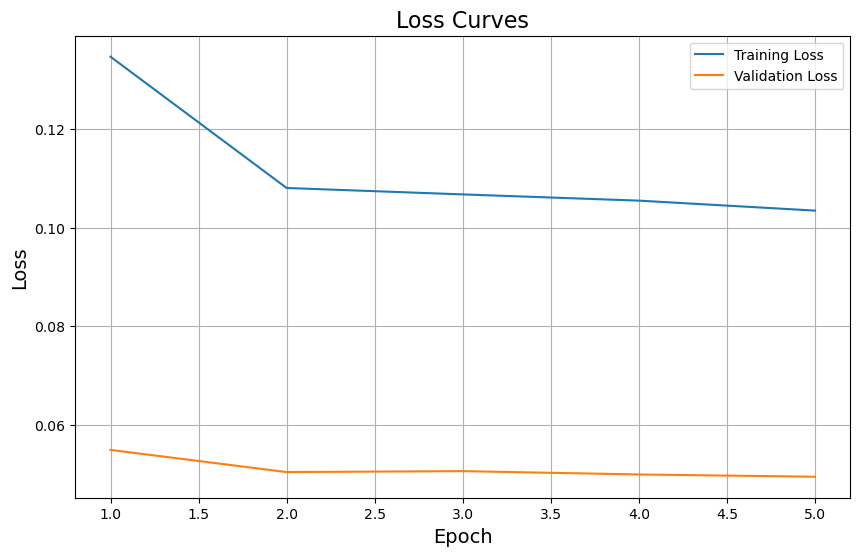

In [41]:
plot_loss_curves(train_loss, valid_loss)

## To save the Pokemon Model

In [16]:
import datetime, torch
timestamp = datetime.datetime.now().strftime("%H:%M:%S %Y_%m_%d")
torch.save(model, './models/working_'+str(epochs)+timestamp+'.pth')


# Perform hamming loss and other metrics (Consolidating predictions for csv writing)

In [63]:
# Assuming you have already defined your test data loader `test_loader`
import torch
# Set the model to evaluation mode
model.eval()

# Define lists to store predictions and ground truth labels
all_outputs = []
all_labels = []
all_pokemons = []
# Iterate over the test data loader
for images, pokemons, labels in test_loader:
    # Forward pass: Pass the images through the model
    with torch.no_grad():
        outputs = model(images)
    # Apply a threshold (e.g., sigmoid) to convert raw logits to probabilities
    

    ####################################
    # print(outputs.sigmoid())
    # print(binary_predictions)
    # print(all_zeros_indices)    
    
    ####################################
    # print(predictions)
    
    # Append predictions and labels to the lists
    all_outputs.append(outputs)
    all_labels.append(labels)
    all_pokemons.append(pokemons)
    

# Concatenate all the batches together along the batch dimension
all_outputs = torch.cat(all_outputs, dim=0)
all_labels = torch.cat(all_labels, dim=0)
from itertools import chain
all_pokemons = list(chain.from_iterable(all_pokemons))

def get_predicted_tensor(output):
    output_ = output.sigmoid()
    # print("output_  ",output_)

    binary_prediction_ = (output > 0.5).int()
    # print("binary_prediction_  ",binary_prediction_)

    all_zeros_indices_ = torch.all(binary_prediction_.bool() == 0)
    # print("all_zeros_indices_  ",all_zeros_indices_)
    
    if all_zeros_indices_:
        # generate new tesor
        max_index = output_.argmax()
        new_tensor = torch.zeros_like(binary_prediction_)
        new_tensor[max_index] = 1
        return new_tensor
    else:
        return binary_prediction_

csv_data  = []

all_prediction_tensors = []
for pokemon, label, output in zip(all_pokemons, all_labels, all_outputs):
    
    predicted_tensor = get_predicted_tensor(output)
    predicted_label = tensor_to_label(mlb,predicted_tensor)

    all_prediction_tensors.append(predicted_tensor)
    
    # print("##################")
    # print("Pokemon: ", pokemon)
    # print("Label_tensor: ", label)
    # print("Label_name: ", tensor_to_label(mlb, label))
    # 
    # print("Predicted_tensor: ", predicted_tensor)
    # print("Predicted_name: ", predicted_label)
    # print("##################")
    csv_data.append((pokemon, predicted_label))

# Calculate accuracy or other metrics
# For example, you can use Hamming loss or other metrics from torchmetrics
# For Hamming loss, you can use `HammingDistance` from `torchmetrics`
hamming_distance = HammingDistance(task='multilabel', num_labels=18)

# Calculate Hamming distance
stacked_predicted_tensors = torch.stack(all_prediction_tensors, dim=0)
hamming_loss = hamming_distance(stacked_predicted_tensors, all_labels)




## (Optional) Model to load from a dumped model

In [47]:

# import torch
# import io
# 
# # Load the model
# model_path = './models/working_50_128dim'  + '.pth'
# with open(model_path, 'rb') as f:
#     buffer = io.BytesIO(f.read())
# 
# model = torch.load(buffer)


## Write to submission.csv

In [64]:
import csv


# Define the path to save the CSV file
csv_file_path = "./submission.csv"

# Open the CSV file in write mode
with open(csv_file_path, mode='w', newline='') as file:
    # Create a CSV writer object
    writer = csv.writer(file)
    
    # Write each row to the CSV file
    for row in csv_data:
        writer.writerow(row)

print("CSV file created successfully!")


CSV file created successfully!


# Kindly note that the predictions.CSV file will have each pokemon mentioned twice and that's because each pokemon class folder had 2 images in it. 